
==== LSTM ====
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step

==== CNN-LSTM ====
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step

==== GRU ====
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step

==== BiLSTM ====
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step

==== Transformer ====
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
3/3 ━━━━━━━━

Best model saved as: CNN-LSTM_best_model_f1_0.9824.h5


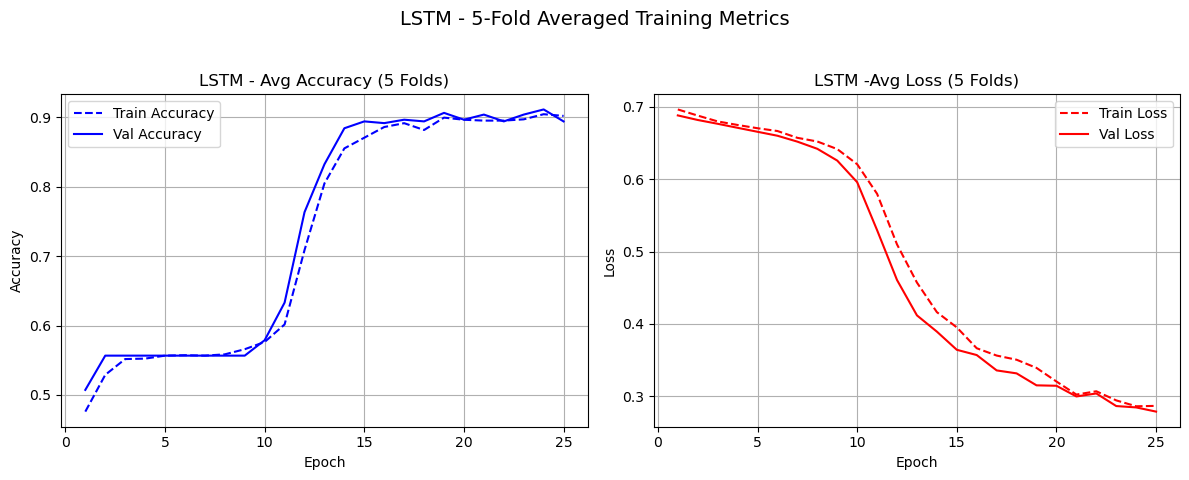

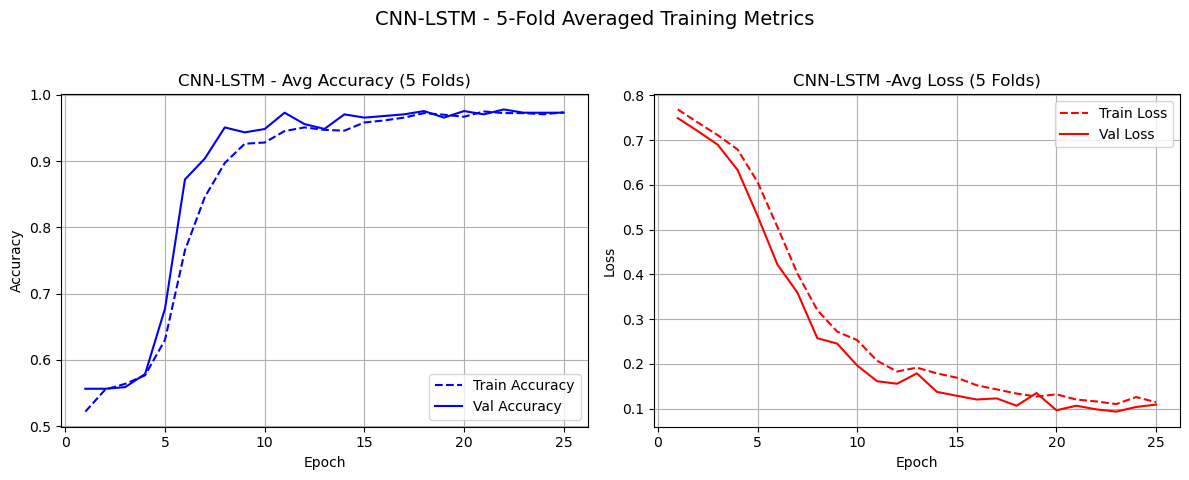

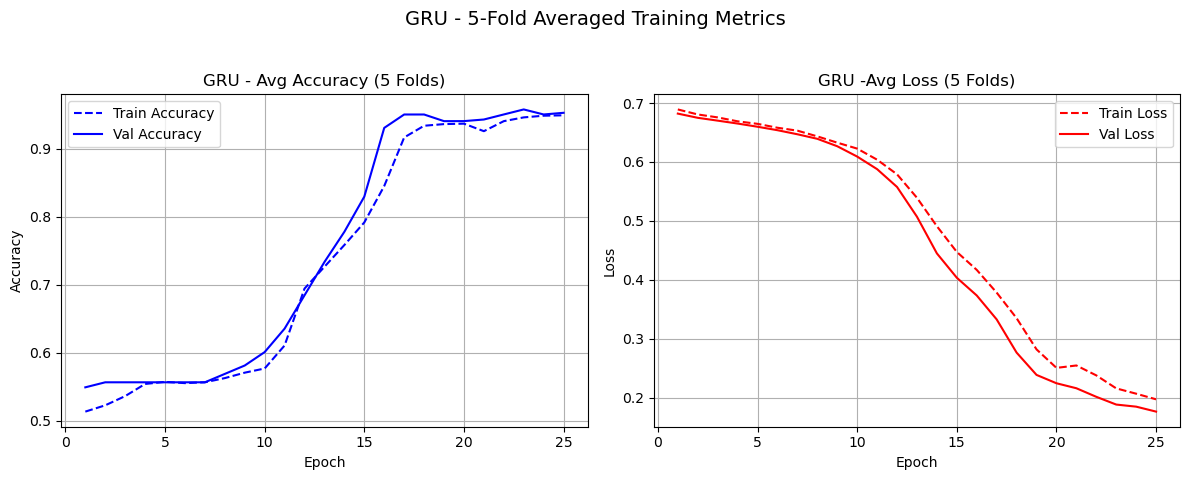

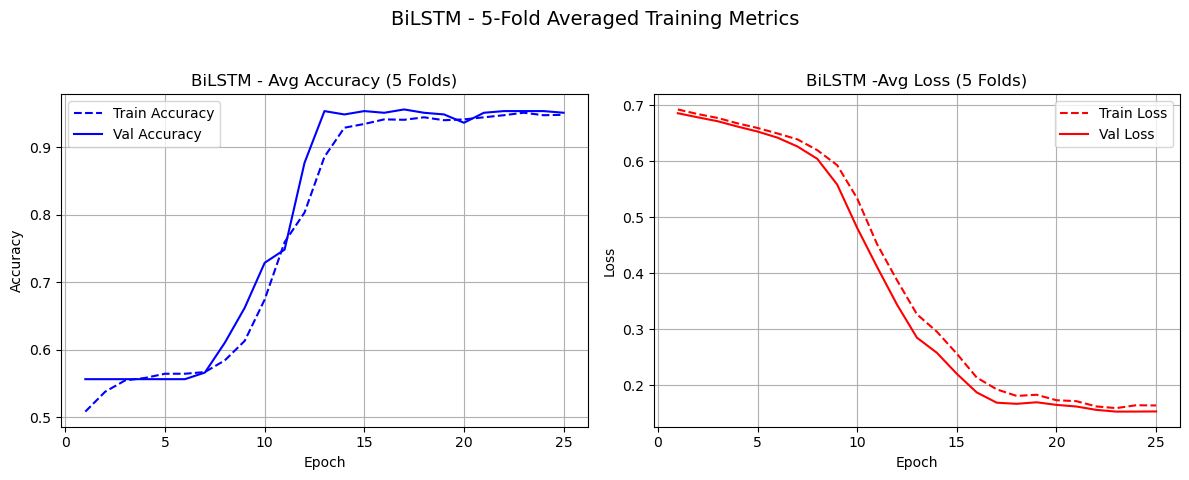

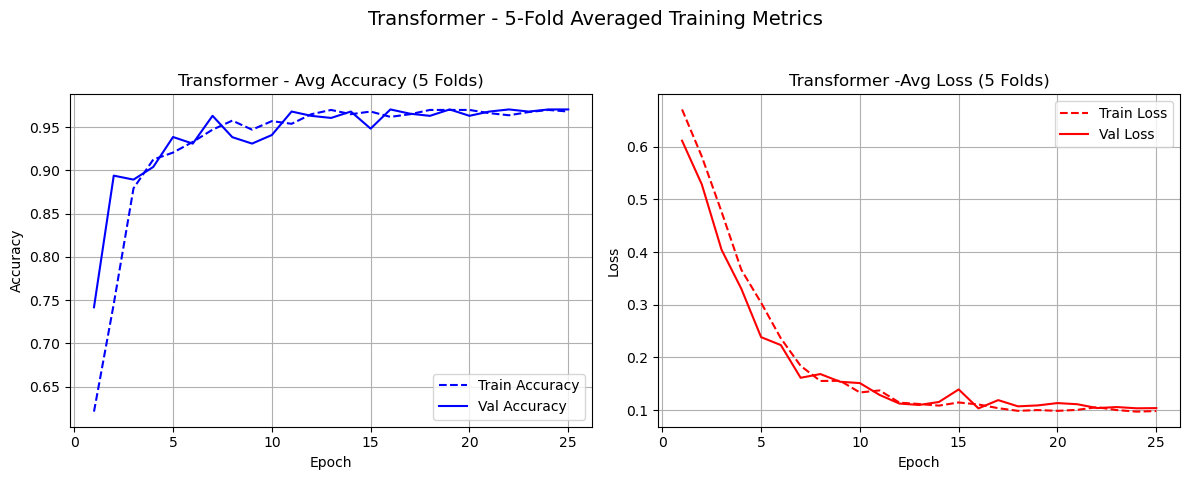

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Add

# -------------------------- Feature Engineering --------------------------
def extract_features(df):
    df = df.copy()
    df["Pulse_Pressure"] = df["Systolic BP (mmHg)"] - df["Diastolic BP (mmHg)"]
    df["MAP"] = df["Diastolic BP (mmHg)"] + (df["Pulse_Pressure"] / 3)
    df["LDL_to_HDL"] = df["LDL"] / (df["HDL"] + 1e-6)
    df["Cholesterol_Ratio"] = df["Cholesterol"] / (df["HDL"] + 1e-6)
    df["HR_SpO2_Ratio"] = df["Heart Rate"] / (df["SpO2"] + 1e-6)
    return df

# -------------------------- Data Loading --------------------------
df_healthy = pd.read_csv("healthy_dataset.csv")
df_unhealthy = pd.read_csv("unhealthy_dataset.csv")
df_healthy["Label"] = "Healthy"
df_unhealthy["Label"] = "Unhealthy"
df = pd.concat([df_healthy, df_unhealthy], ignore_index=True)
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df["Label"] = LabelEncoder().fit_transform(df["Label"])
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df["Label"] = LabelEncoder().fit_transform(df["Label"])

# --- Handle Missing Values ---

df = extract_features(df)

X = df.drop(columns=["Label"])
y = df["Label"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# -------------------------- Noise Injection --------------------------
def add_noise(X, noise_level=0.005):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

# -------------------------- Lightweight Transformer --------------------------
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, padding='same', activation='relu')(inputs)
    attn_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    out1 = LayerNormalization()(Add()([x, attn_output]))
    ff = Dense(64, activation='relu')(out1)
    ff = Dense(32)(ff)
    out2 = LayerNormalization()(Add()([out1, ff]))
    x = GlobalAveragePooling1D()(out2)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# -------------------------- Model Definitions --------------------------
models = {
    "LSTM": lambda input_shape: Sequential([
        Input(shape=input_shape),
        LSTM(16, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),

   "CNN-LSTM": lambda input_shape: Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),  # Increase number of filters and change kernel size
    Dropout(0.3),  # Increase dropout rate if overfitting
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),  # Additional Conv1D layer
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),  # Increase LSTM units
    Dropout(0.3),
    Dense(16, activation='relu'),  # Increased complexity in Dense layers
    Dense(1, activation='sigmoid')
]),

    "GRU": lambda input_shape: Sequential([
        Input(shape=input_shape),
        GRU(16, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),

    "BiLSTM": lambda input_shape: Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(16, kernel_regularizer=l2(0.001))),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),

    "Transformer": build_transformer
}

# -------------------------- Training and Evaluation --------------------------
results = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epoch_metrics = {}

for model_name, build_model in models.items():
    print(f"\n==== {model_name} ====")
    accs, precs, recs, f1s = [], [], [], []
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    per_epoch = defaultdict(list)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), 1):
        X_train, X_test = X_scaled_reshaped[train_idx], X_scaled_reshaped[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train = add_noise(X_train)

        model = build_model(X_train.shape[1:])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6)
        early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[reduce_lr, early_stop],
            verbose=0
        )

        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        accs.append((y_pred == y_test).mean())
        precs.append(precision_score(y_test, y_pred))
        recs.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        train_losses.append(np.min(history.history['loss']))
        val_losses.append(np.min(history.history['val_loss']))
        train_accs.append(np.max(history.history['accuracy']))
        val_accs.append(np.max(history.history['val_accuracy']))

        for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
            hist = history.history[key]
            padded = hist + [hist[-1]] * (25 - len(hist))  # pad with last value
            per_epoch[key].append(padded)


    epoch_metrics[model_name] = {
        key: np.mean(per_epoch[key], axis=0)
        for key in ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    }

    results[model_name] = {
        "Accuracy": np.mean(accs),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1 Score": np.mean(f1s),
        "Train Loss": np.mean(train_losses),
        "Val Loss": np.mean(val_losses),
        "Train Accuracy": np.mean(train_accs),
        "Val Accuracy": np.mean(val_accs)
    }

# -------------------------- Summary & Best Model --------------------------
results_df = pd.DataFrame(results).T.round(4)
print("\n📊 Model Comparison (Average over 5 folds):")
print(results_df)

best_model_name = results_df['F1 Score'].idxmax()
print(f"\n🏆 Best Model: {best_model_name} with F1 Score = {results_df.loc[best_model_name, 'F1 Score']}")

# -------------------------- Save Best Model --------------------------
best_model = models[best_model_name](X_train.shape[1:])  # Rebuild the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Re-train the best model on the entire dataset
history = best_model.fit(
    X_scaled_reshaped, y,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6),
               EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
    verbose=1
)

# Save the best model with its F1 score in the filename
best_f1_score = results_df.loc[best_model_name, 'F1 Score']
best_model_filename = f"{best_model_name}_best_model_f1_{best_f1_score:.4f}.h5"
best_model.save(best_model_filename)

print(f"Best model saved as: {best_model_filename}")


# -------------------------- Average Epoch-wise Plots --------------------------
# -------------------------- Separate Epoch-wise Plots per Model --------------------------
epochs = np.arange(1, 26)

for model_name, metrics in epoch_metrics.items():
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['accuracy'], label='Train Accuracy', linestyle='--', color='blue')
    plt.plot(epochs, metrics['val_accuracy'], label='Val Accuracy', color='blue')
    plt.title(f"{model_name} - Avg Accuracy (5 Folds)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['loss'], label='Train Loss', linestyle='--', color='red')
    plt.plot(epochs, metrics['val_loss'], label='Val Loss', color='red')
    plt.title(f"{model_name} -Avg Loss (5 Folds)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.suptitle(f"{model_name} - 5-Fold Averaged Training Metrics", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [46]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load model
model = load_model("CNN-LSTM_best_model_f1_0.9824.h5")

# Step 1: Load data
df_healthy = pd.read_csv("healthy_dataset.csv")
df_unhealthy = pd.read_csv("unhealthy_dataset.csv")
df_healthy["Label"] = "Healthy"
df_unhealthy["Label"] = "Unhealthy"
df = pd.concat([df_healthy, df_unhealthy], ignore_index=True)

# Step 2: Encode and create features
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df["Label"] = LabelEncoder().fit_transform(df["Label"])
df.dropna(inplace=True)

def extract_features(df):
    df = df.copy()
    df["Pulse_Pressure"] = df["Systolic BP (mmHg)"] - df["Diastolic BP (mmHg)"]
    df["MAP"] = df["Diastolic BP (mmHg)"] + (df["Pulse_Pressure"] / 3)
    df["LDL_to_HDL"] = df["LDL"] / (df["HDL"] + 1e-6)
    df["Cholesterol_Ratio"] = df["Cholesterol"] / (df["HDL"] + 1e-6)
    df["HR_SpO2_Ratio"] = df["Heart Rate"] / (df["SpO2"] + 1e-6)
    return df

df = extract_features(df)

X = df.drop(columns=["Label"])
y = df["Label"]

# Step 3: Fit scaler
scaler = MinMaxScaler()
scaler.fit(X)  # fit only once on training data

# Step 4: Prediction function
def predict_atherosclerosis(input_data, model, scaler, feature_columns):
    input_df = pd.DataFrame([input_data], columns=[
        "Age", "Gender", "Glucose", "Cholesterol", "LDL", "HDL", "GSR",
        "Systolic BP (mmHg)", "Diastolic BP (mmHg)", "SpO2", "Heart Rate",
        "HRV", "ECG", "Weight"  # Include 'Weight' as part of input data
    ])

    input_hybrid = extract_features(input_df)
    input_hybrid = input_hybrid[feature_columns]
    input_scaled = scaler.transform(input_hybrid)
    input_reshaped = input_scaled.reshape(1, input_scaled.shape[1], 1)

    prediction = model.predict(input_reshaped)[0][0]
    result = "Unhealthy (At Risk)" if prediction > 0.5 else "Healthy"
    return result

# Simulated example patient input
new_patient = [21, 0, 76.6, 149, 89, 60, 68.12, 99, 54, 96.1, 93, 1.46, 90, 34]  # Example input with 'Weight'
feature_columns = X.columns.tolist()  # Include 'Weight' in feature columns
result = predict_atherosclerosis(new_patient, model=model, scaler=scaler, feature_columns=feature_columns)
print("Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Prediction: Healthy


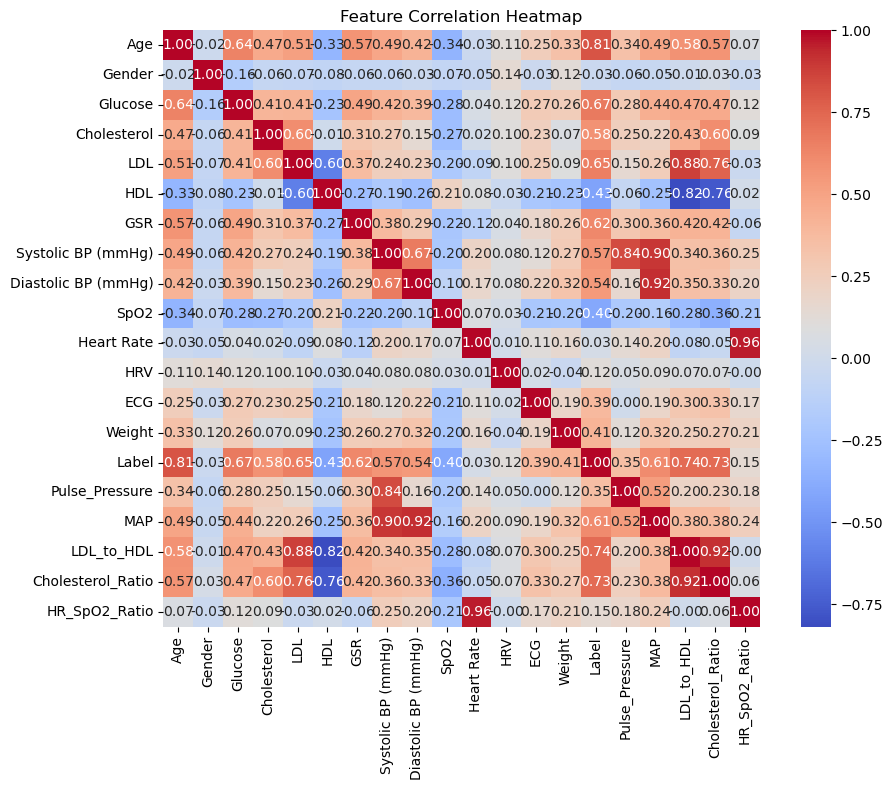

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Set plot size
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)

# Title
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [19]:
begin -> end
begin <- end

SyntaxError: invalid syntax (1181254083.py, line 1)